In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.interpolate import SmoothBivariateSpline
import warnings
import matplotlib.cm as cm
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
def black_scholes_call(S, K, T, r, sigma):
    if T == 0:
        return max(0, S - K)
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate call price
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))

    return call_price

def black_scholes_put(S, K, T, r , sigma):
     # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate call price
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))

    # Calculate put price using put-call parity
    put_price = call_price - S + K * np.exp(-r * T)

    return put_price

In [3]:
def get_heston_parameters(ticker):
    # Fetch historical data and market data
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    market_index_ticker= '^GSPC'
    t_bill = yf.Ticker("^IRX") #treasury bill
    market_data = yf.download(market_index_ticker)['Close']

    
    # Spot price
    S0 = hist['Close'].iloc[-1]
    
    # Log returns
    hist['LogReturn'] = np.log(hist['Close'] / hist['Close'].shift(1))
    log_returns = hist['LogReturn'].dropna()
    
    # Initial variance
    v0 = np.var(log_returns)
    
    # Risk-free rate pulled from ^IRX
    
    t_bill_data = t_bill.history(period="1d")
    r = float((t_bill_data['Close'].iloc[-1])/100)
    
    # Estimate long-term variance (theta) and rate of mean reversion (kappa)
    theta = np.mean(log_returns**2)
    kappa = 1 / np.mean(hist.index.to_series().diff().dt.days.dropna().values) 
    
    # Estimate sigma
    sigma = np.std(log_returns)
    
    # Estimate correlation between stock returns and variance
    log_returns_shifted = log_returns.shift(-1).dropna()
    log_returns = log_returns.iloc[:-1]
    slope, intercept, r_value, p_value, std_err = linregress(log_returns, log_returns_shifted)
    rho = r_value
    
    
    print(f"Estimated Heston Model Parameters for {ticker}:")
    print(f"Spot Price (S0): {S0}")
    print(f"Initial Variance (v0): {v0}")
    print(f"Risk-free Rate (r): {r}")
    print(f"Rate of Mean Reversion (kappa): {kappa}")
    print(f"Long-term Variance (theta): {theta}")
    print(f"Volatility of Volatility (sigma): {sigma}")
    print(f"Correlation (rho): {rho}")
    
    
    return  S0, v0, r, kappa, theta, sigma, rho

def heston_model_simulation(S0, v0, r, kappa, theta, sigma, rho, T, steps, paths):
    dt = T / steps
    S = np.zeros((steps + 1, paths))
    v = np.zeros((steps + 1, paths))
    S[0] = S0
    v[0] = v0

    for t in range(1, steps + 1):
        Z1 = np.random.normal(size=paths)
        Z2 = np.random.normal(size=paths)
        W_S = Z1
        W_v = rho * Z1 + np.sqrt(1 - rho**2) * Z2
        
        v[t] = np.maximum(v[t-1] + kappa * (theta - v[t-1]) * dt + sigma * np.sqrt(v[t-1] * dt) * W_v, 0)
        S[t] = S[t-1] * np.exp((r - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1] * dt) * W_S)

    return S

In [4]:
ticker = 'LMT'
S0, v0, r, kappa, theta, sigma, rho= get_heston_parameters(ticker)
T = float(float(input("Time to Maturity in days: ")) / 365)
steps = 252  # Number of time steps (daily)
paths = 10000  # Number of paths in the simulation

[*********************100%%**********************]  1 of 1 completed


Estimated Heston Model Parameters for LMT:
Spot Price (S0): 466.1099853515625
Initial Variance (v0): 0.00011236752747148976
Risk-free Rate (r): 0.052330002784729004
Rate of Mean Reversion (kappa): 0.6887052341597797
Long-term Variance (theta): 0.0001123947719297956
Volatility of Volatility (sigma): 0.010600355063463194
Correlation (rho): -0.045848743988914524


IMPLIED VOLATILITY



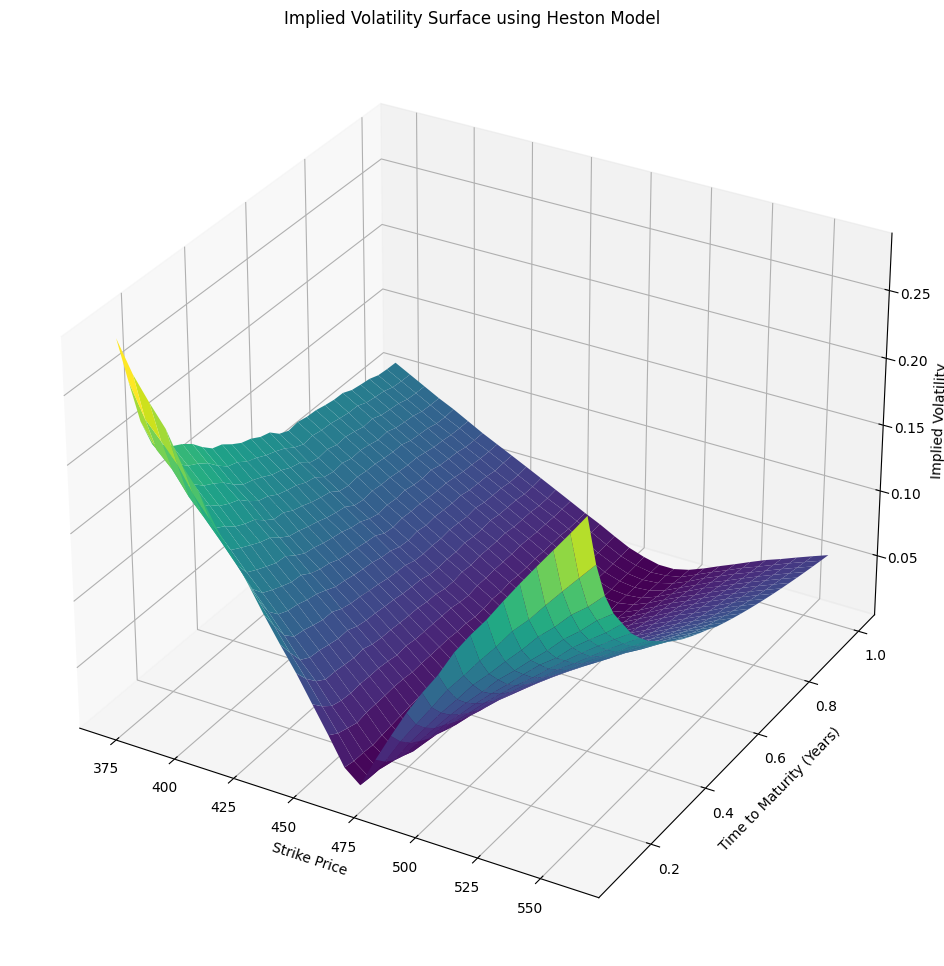

In [5]:
def implied_volatility(S, K, T, r, market_price):
    def objective(sigma):
        return black_scholes_call(S, K, T, r, sigma) - market_price
    
    epsilon = 1e-5 # Small number for numerical differentiation
    sigma_guess = 0.35  # Initial guess
    price_plus = black_scholes_call(S, K, T, r, sigma_guess + epsilon)
    price_minus = black_scholes_call(S, K, T, r, sigma_guess - epsilon)
    vega = (price_plus - price_minus) / (2 * epsilon)
    
    for i in range(100):
        price = black_scholes_call(S, K, T, r, sigma_guess)
        diff = market_price - price
        if abs(diff) < 1e-1: # This margin can be adjusted and drastically changes the output of the surface
            return sigma_guess
        sigma_guess += diff / vega
    
    return None

strike_prices = np.linspace(S0 * 0.8, S0 * 1.2, 30)  # Increased resolution for strike prices
maturities = np.linspace(30, 365, 30) / 365  # Increased resolution for maturities

S = heston_model_simulation(S0, v0, r, kappa, theta, sigma, rho, max(maturities), steps, paths)

# Calculate implied volatilities

#Arrays of zeroes to store the implied volatilities
implied_vols = np.zeros((len(strike_prices), len(maturities)))
data = []

for i, K in enumerate(strike_prices):
    for j, T in enumerate(maturities):
        market_price = np.mean(np.maximum(S[int(T * steps), :] - K, 0)) * np.exp(-r * T)
        implied_vol = implied_volatility(S0, K, T, r, market_price)
        implied_vols[i, j] = implied_vol
        data.append([K, T, implied_vol])

# Create a 3D plot for the volatility surface
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(strike_prices, maturities)
Z= implied_vols.T

ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity (Years)')
ax.set_zlabel('Implied Volatility')
plt.title('Implied Volatility Surface using Heston Model')
plt.show()

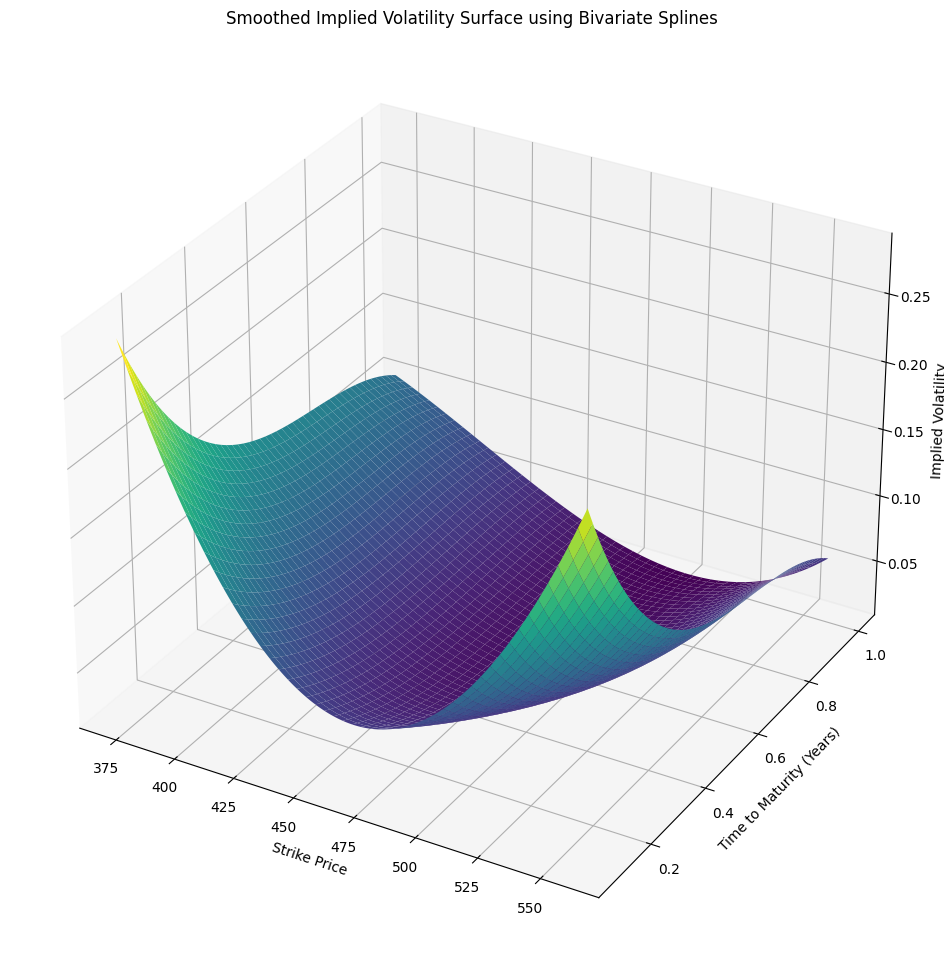

In [6]:
# Flatten the arrays for Bivariate Spline
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Fit the bivariate spline
spline = SmoothBivariateSpline(X_flat, Y_flat, Z_flat, s=0.5)

# Smoother surface increments
x_pred = np.linspace(S0*0.8, S0*1.2, 1000)
y_pred = np.linspace(30, 365, 1000)/365  # Converting to Years
X_pred, Y_pred = np.meshgrid(x_pred, y_pred)

Z_pred = spline.ev(X_pred.ravel(), Y_pred.ravel()).reshape(X_pred.shape)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_pred, Y_pred, Z_pred, cmap='viridis')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity (Years)')
ax.set_zlabel('Implied Volatility')
plt.title('Smoothed Implied Volatility Surface using Bivariate Splines')
plt.show()

In [8]:
# Generate market data using Monte Carlo simulations
def generate_market_data(spot_price, num_samples=10000):
    strike_prices = np.random.uniform(S0 *0.8, S0*1.2, num_samples)
    times_to_maturity = np.random.uniform(0.2, 1.0, num_samples)
    
    # Calculate moneyness
    moneyness = spot_price / strike_prices
    
    # Simulate bid-ask spreads with some noise
    spreads = 0.01 + 0.02 * (1 - moneyness) + 0.01 * times_to_maturity + np.random.normal(0, 0.01, num_samples)
    
    data = pd.DataFrame({
        'Strike Price': strike_prices,
        'Time to Maturity': times_to_maturity,
        'Moneyness': moneyness,
        'Spread': spreads
    })
    return data

# Function to find the coefficients of the dynamic spread equation
def find_spread_coefficients(market_data):
    #Linear Regression
    X = market_data[['Moneyness', 'Time to Maturity']]
    y = market_data['Spread']
    reg = LinearRegression().fit(X, y)
    
    # Extract the coefficients
    base_spread = reg.intercept_
    moneyness_coeff = reg.coef_[0]
    maturity_coeff = reg.coef_[1]
    
    return base_spread, moneyness_coeff, maturity_coeff

market_data = generate_market_data(S0)
base_spread, moneyness_coeff, maturity_coeff = find_spread_coefficients(market_data)

#Use the coefficients to calculate the dynamic spread
def dynamic_spread(price, moneyness, time_to_maturity, base_spread=base_spread, moneyness_coeff=moneyness_coeff, maturity_coeff=maturity_coeff):
    spread = base_spread + moneyness_coeff * (1 - moneyness) + maturity_coeff * time_to_maturity
    bid = price * (1 - spread)
    ask = price * (1 + spread)
    return bid, ask


In [9]:
smoothed_data = []

for i, K in enumerate(strike_prices):
    for j, T in enumerate(maturities):
        implied_vol = spline.ev(K, T)
        call_price = black_scholes_call(S0, K, T, r, implied_vol)
        put_price = black_scholes_put(S0, K, T, r, implied_vol)
        
        # Calculate moneyness
        moneyness = S0 / K
        
        # Apply the dynamic spread to get bid and ask prices
        call_bid, call_ask = dynamic_spread(call_price, moneyness, T)
        put_bid, put_ask = dynamic_spread(put_price, moneyness, T)
        call_spread= call_ask - call_bid
        put_spread= put_ask - put_bid
        
        smoothed_data.append([K, T, implied_vol, call_bid, call_ask, put_bid, put_ask, call_spread, put_spread])

# Create DataFrame
df_smoothed = pd.DataFrame(smoothed_data, columns=['Strike Price', 'Time to Maturity', 'Implied Volatility', 'Call Bid', 'Call Ask', 'Put Bid', 'Put Ask', 'Call Spread', 'Put Spread'])

# Display the DataFrame
df_smoothed

,Strike Price,Time to Maturity,Implied Volatility,Call Bid,Call Ask,Put Bid,Put Ask,Call Spread,Put Spread
0,372.887988,0.082192,0.28814996419300837,91.316127,98.389735,0.029412,0.031690,7.073608,0.002278
1,372.887988,0.113840,0.26723551754154695,91.911825,99.093892,0.063588,0.068557,7.182067,0.004969
2,372.887988,0.145489,0.2483224044488438,92.500560,99.791385,0.092165,0.099429,7.290825,0.007264
3,372.887988,0.177137,0.23130389467044307,93.076872,100.476307,0.109679,0.118399,7.399435,0.008719
4,372.887988,0.208786,0.21607325796188873,93.641396,101.149321,0.116767,0.126129,7.507924,0.009362
...,...,...,...,...,...,...,...,...,...
895,559.331982,0.873406,0.0764713619397271,0.368475,0.396251,66.123169,71.107482,0.027775,4.984314
896,559.331982,0.905054,0.07295568351153986,0.327908,0.352848,65.209335,70.168886,0.024939,4.959551
897,559.331982,0.936703,0.0686802143773711,0.266768,0.287237,64.276892,69.209044,0.020470,4.932152
898,559.331982,0.968351,0.06352652322574392,0.190577,0.205329,63.331360,68.233866,0.014753,4.902505


In [10]:
# Save to CSV file
df_smoothed.to_csv('heston_surface_with_bid_ask.csv', index=True)

In [7]:
#Check Research Papers to see what models are being used for arb-free surface (Heston, SABR, etc.)
#Midpoint exploration